# Preprocessing audio from ESC50 to create numpy arrays

This notebook covers the basic steps required to generate numpy arrays containing a preprocessed dataset, from a ESC50 dataset.
The preprocessing stages load audio files, then perform a set of predefined data augmentations, in alignment with the paper [Environmental Sound Classification on Microcontrollers using Convolutional Neural Networks](https://github.com/jonnor/ESC-CNN-microcontroller/releases/download/print1/report-print1.pdf),

The above paper refers to a set of 12 Data Augmentations to apply to each audio file, from [Deep Convolutional Neural Networks and Data
Augmentation for Environmental Sound
Classification](https://arxiv.org/pdf/1608.04363.pdf), which are applied one at a time.  The end result is that <ins>13</ins> spectrograms are created for each audio file in the ESC50 dataset
 - pitch shifting = [-2, -1, 1, 2] and [-3.5, -2.5, 2.5, 3.5]
 - time stretching = [0.81, 0.93, 1.07, 1.23]


## 1. Install and import the prerequisites

In [1]:
!pip install -q parse tqdm numpy scipy librosa soundfile matplotlib
import os
from ml_utilities import ESC50

## 2. Fetch the ESC50 dataset
Preprocessing a dataset requires local access to an instance.  This can be downloaded on the fly if required.

In [2]:
# Fetching a copy of the ESC50 dataset
esc50_path = '/Volumes/Samsung_T5/DataSet Preparation/ESC-50 stuff/ESC-50'
if not os.path.exists(esc50_path):
    !git clone https://github.com/karolpiczak/ESC-50.git $esc50_path

In [3]:
# Loading the ESC50 dataset, using the module
esc50 = ESC50(esc50_path)

In [4]:
preprocessed = esc50.generate_jonnor_mel_spectrograms(cache_path='/Volumes/Samsung_T5/tests/')

Setting: 0it [00:00, ?it/s]


## 4. Preprocess the data
The data set can take some time, and as the librosa library does not support GPU processing, this is also done on the CPU.  A progress meter will guide the user to determine the time remaining.  A cache path creates a 'pickle' file, in the folder which contains the final dataset.  The process can be resumed, but 

Jump to step 7 for MNIST conversion.

## 5. Results
The returned tuple contains the extracted proprocessed audio files converted into 2D numpy arrays.  Due to the data augmentation, the shape of the resulting numpy arrays is not consistent. See below for further specific detail regarding the array shape.  As a result of the varying shape and to support subsequent processing, the spectrogram data remains in a 2d array.  Furthermore as no specific spectrogram transformation (i.e. log Mel) was provided, the spectrogram output is raw, floating point.

In [5]:
print(f'Total preprocessed records: {len(preprocessed)}')

Total preprocessed records: 26000


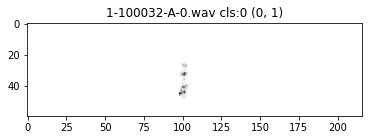

In [6]:
import numpy as np
import matplotlib.pyplot as plt

record_number  = 0
fold, filename, target, category, take, spectrogram, settings = preprocessed[record_number]

plt.subplot(111)
plt.imshow(np.flip(spectrogram,0), cmap='gray_r')
plt.title(f'{filename} cls:{target} {str(settings)}')
plt.show()

## 6. Analysis of result
Use of the preprocessed record tuple is straight-forward

## 7. Creation of MNIST style data from the preprocessed data
Simple iterative data processing can convert the resulting spectrogram into an MNIST style output

In [7]:
x_train,y_train, s_train, x_test, y_test, s_test = esc50.generate_jonnor_mnist(preprocessed, train_folds= [1,2,3,4], test_folds=[5])

In [8]:
print(f'Preprocessed spectrograms have the following sizes {np.unique([f"{s}" for s in s_train])}')
print(f'Postprocessed spectrograms have the following sizes {np.unique([f"{s.shape}" for s in x_train])}')

Preprocessed spectrograms have the following sizes ['(60, 176)' '(60, 202)' '(60, 216)' '(60, 232)' '(60, 266)']
Postprocessed spectrograms have the following sizes ['(10560,)' '(12120,)' '(12960,)' '(13920,)' '(15960,)']


## 8. Saving numpy arrays
Whilst the cache record is available, its a pickle file, which is not the preferred method of storage for shared data, as opening a pickle may execute code.  It is therefore important to store the resulting data in numpy save format.

In [12]:
with open('/Volumes/Samsung_T5/tests/jonnor_esc50_1024_512_mel.npy', 'wb') as f:
    np.save(f, np.array(preprocessed))

with open('/Volumes/Samsung_T5/tests/mnist_esc50_1024_512_mel.npy', 'wb') as f:
    np.save(f, np.array((x_train,y_train,s_train,x_test,y_test,s_test)))

## 9. Shape information
Due to data augmentation, the spectrograms vary in shape, and this information has not been lost.
The s_train, and s_test arrays resulting from the MNIST conversion contain the original shape, whilst the x_train and x_test arrays are flattened.

Text(0.5, 1.0, 'Train Record 0 ((60, 216)) Target:0')

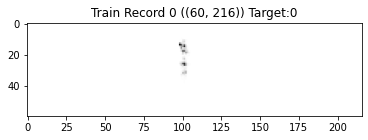

In [9]:
record_number = 0
plt.imshow(x_train[record_number].reshape(s_train[record_number]), cmap='gray_r')
plt.title(f'Train Record {record_number} ({s_train[record_number]}) Target:{y_train[record_number]}')